In [1]:
import matplotlib.pyplot as plt

import openmoc
import openmoc.plotter as plotter
import openmoc.process as process
from openmoc.materialize import load_from_hdf5

%matplotlib inline

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Simulation Runtime Parameters

In [2]:
num_threads = 4
azim_spacing = 0.05
num_azim = 16
tolerance = 1E-5
max_iters = 50

## Initialize Materials

In [3]:
materials = load_from_hdf5(filename='c5g7-mgxs.h5', directory='..')
print materials.keys()

['UO2', 'MOX-8.7%', 'Fission Chamber', 'MOX-4.3%', 'Water', 'MOX-7%', 'Control Rod', 'Guide Tube']


## Create Bounding Surfaces

In [4]:
# Create ZCylinder for the fuel
fuel_radius = openmoc.ZCylinder(x=0.0, y=0.0, radius=0.54)

In [5]:
# Create planes to bound the entire geometry
left = openmoc.XPlane(x=-10.71, name='left')
right = openmoc.XPlane(x=10.71, name='right')
top = openmoc.YPlane(y=10.71, name='top')
bottom = openmoc.YPlane(y=-10.71, name='bottom')

left.setBoundaryType(openmoc.REFLECTIVE)
right.setBoundaryType(openmoc.REFLECTIVE)
top.setBoundaryType(openmoc.REFLECTIVE)
bottom.setBoundaryType(openmoc.REFLECTIVE)

## Create Fuel Pins

In [6]:
# 4.3% MOX pin cell
mox43_cell = openmoc.Cell()
mox43_cell.setFill(materials['MOX-4.3%'])
mox43_cell.setNumRings(3)
mox43_cell.setNumSectors(8)
mox43_cell.addSurface(-1, fuel_radius)

mox43 = openmoc.Universe(name='MOX-4.3%')
mox43.addCell(mox43_cell)

In [7]:
# 7% MOX pin cell
mox7_cell = openmoc.Cell()
mox7_cell.setFill(materials['MOX-7%'])
mox7_cell.setNumRings(3)
mox7_cell.setNumSectors(8)
mox7_cell.addSurface(-1, fuel_radius)

mox7 = openmoc.Universe(name='MOX-7%')
mox7.addCell(mox7_cell)

In [8]:
# 8.7% MOX pin cell
mox87_cell = openmoc.Cell()
mox87_cell.setFill(materials['MOX-8.7%'])
mox87_cell.setNumRings(3)
mox87_cell.setNumSectors(8)
mox87_cell.addSurface(-1, fuel_radius)

mox87 = openmoc.Universe(name='MOX-8.7%')
mox87.addCell(mox87_cell)

In [9]:
# Fission chamber pin cell
fission_chamber_cell = openmoc.Cell()
fission_chamber_cell.setFill(materials['Fission Chamber'])
fission_chamber_cell.setNumRings(3)
fission_chamber_cell.setNumSectors(8)
fission_chamber_cell.addSurface(-1, fuel_radius)

fission_chamber = openmoc.Universe(name='Fission Chamber')
fission_chamber.addCell(fission_chamber_cell)

In [10]:
# Guide tube pin cell
guide_tube_cell = openmoc.Cell()
guide_tube_cell.setFill(materials['Guide Tube'])
guide_tube_cell.setNumRings(3)
guide_tube_cell.setNumSectors(8)
guide_tube_cell.addSurface(-1, fuel_radius)

guide_tube = openmoc.Universe(name='Guide Tube')
guide_tube.addCell(guide_tube_cell)

In [11]:
# Moderator rings
moderator = openmoc.Cell()
moderator.setFill(materials['Water'])
moderator.addSurface(+1, fuel_radius)
moderator.setNumRings(3)
moderator.setNumSectors(8)

In [12]:
# Add moderator rings to each pin cell
pins = [mox43, mox7, mox87, fission_chamber, guide_tube]
for pin in pins:
    pin.addCell(moderator)

In [13]:
# CellFills for the assembly
assembly1_cell = openmoc.Cell(name='Assembly 1')

assembly1 = openmoc.Universe(name='Assembly 1')
assembly1.addCell(assembly1_cell)

## Create Fuel Assembly

In [14]:
# A mixed enrichment PWR MOX fuel assembly
assembly = openmoc.Lattice(name='MOX Assembly')
assembly.setWidth(width_x=1.26, width_y=1.26)

# Create a template to map to pin cell types
template = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
            [1, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 1],
            [1, 2, 2, 4, 2, 3, 3, 3, 3, 3, 3, 3, 2, 4, 2, 2, 1],
            [1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1],
            [1, 2, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 2, 1],
            [1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1],
            [1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1],
            [1, 2, 4, 3, 3, 4, 3, 3, 5, 3, 3, 4, 3, 3, 4, 2, 1],
            [1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1],
            [1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1],
            [1, 2, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 2, 1],
            [1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1],
            [1, 2, 2, 4, 2, 3, 3, 3, 3, 3, 3, 3, 2, 4, 2, 2, 1],
            [1, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 1],
            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

universes = {1 : mox43, 2 : mox7, 3 : mox87,
             4 : guide_tube, 5 : fission_chamber}

for i in range(17):
    for j in range(17):
        template[i][j] = universes[template[i][j]]

assembly.setUniverses([template])

In [15]:
# Root Cell/Universe
root_cell = openmoc.Cell(name='Full Geometry')
root_cell.setFill(assembly)
root_cell.addSurface(+1, left)
root_cell.addSurface(-1, right)
root_cell.addSurface(-1, top)
root_cell.addSurface(+1, bottom)

root_universe = openmoc.Universe(name='Root Universe')
root_universe.addCell(root_cell)

## Initialize CMFD

In [16]:
cmfd = openmoc.Cmfd()
cmfd.setSORRelaxationFactor(1.5)
cmfd.setLatticeStructure(17,17)
cmfd.setGroupStructure([[1,2,3], [4,5,6,7]])
cmfd.setKNearest(3)

## Initialize Geometry

In [17]:
geometry = openmoc.Geometry()
geometry.setRootUniverse(root_universe)
geometry.setCmfd(cmfd)

[  NORMAL ]  Plotting the materials...


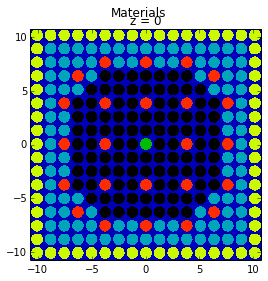

In [18]:
# Plot the geometry color-coded by materials
fig = plotter.plot_materials(geometry, gridsize=500, get_figure=True)
fig.set_figheight(4)
plt.show()

[  NORMAL ]  Plotting the cells...


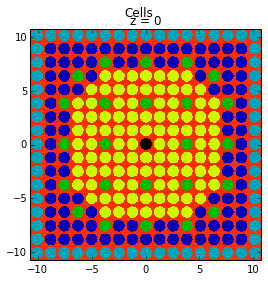

In [19]:
# Plot the geometry color-coded by cells
fig = plotter.plot_cells(geometry, gridsize=500, get_figure=True)
fig.set_figheight(4)
plt.show()

## Initialize TrackGenerator

In [20]:
track_generator = openmoc.TrackGenerator(geometry, num_azim, azim_spacing)
track_generator.setNumThreads(num_threads)
track_generator.generateTracks()

[  NORMAL ]  Importing ray tracing data from file...


[  NORMAL ]  Plotting the flat source regions...


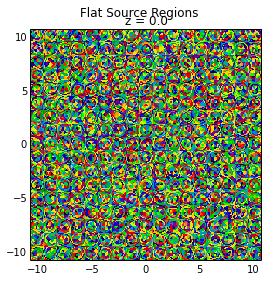

In [21]:
# Plot the geometry color-coded by flat source region
fig = plotter.plot_flat_source_regions(geometry, gridsize=500, get_figure=True)
fig.set_figheight(4)
plt.show()

[  NORMAL ]  Plotting the CMFD cells...


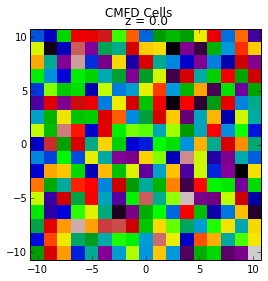

In [22]:
# Plot the geometry color-coded by CMFD cells
fig = plotter.plot_cmfd_cells(geometry, cmfd, gridsize=500, get_figure=True)
fig.set_figheight(4)
plt.show()

## Run Simulation

In [23]:
solver = openmoc.CPUSolver(track_generator)
solver.setConvergenceThreshold(tolerance)
solver.setNumThreads(num_threads)
solver.computeEigenvalue(max_iters)

[  NORMAL ]  Computing the eigenvalue...
[  NORMAL ]  Iteration 0:	k_eff = 1.463820	res = 0.000E+00
[  NORMAL ]  Iteration 1:	k_eff = 1.378956	res = 2.531E-01
[  NORMAL ]  Iteration 2:	k_eff = 1.300903	res = 1.234E-01
[  NORMAL ]  Iteration 3:	k_eff = 1.249353	res = 1.039E-01
[  NORMAL ]  Iteration 4:	k_eff = 1.219282	res = 5.247E-02
[  NORMAL ]  Iteration 5:	k_eff = 1.202671	res = 2.703E-02
[  NORMAL ]  Iteration 6:	k_eff = 1.193514	res = 1.250E-02
[  NORMAL ]  Iteration 7:	k_eff = 1.188467	res = 5.650E-03
[  NORMAL ]  Iteration 8:	k_eff = 1.185685	res = 2.749E-03
[  NORMAL ]  Iteration 9:	k_eff = 1.184159	res = 1.789E-03
[  NORMAL ]  Iteration 10:	k_eff = 1.183329	res = 1.365E-03
[  NORMAL ]  Iteration 11:	k_eff = 1.182881	res = 1.026E-03
[  NORMAL ]  Iteration 12:	k_eff = 1.182642	res = 7.313E-04
[  NORMAL ]  Iteration 13:	k_eff = 1.182513	res = 4.946E-04
[  NORMAL ]  Iteration 14:	k_eff = 1.182441	res = 3.188E-04
[  NORMAL ]  Iteration 15:	k_eff = 1.182400	res = 1.972E-04
[  NORMAL

[  NORMAL ]  Plotting the FSR scalar fluxes...


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


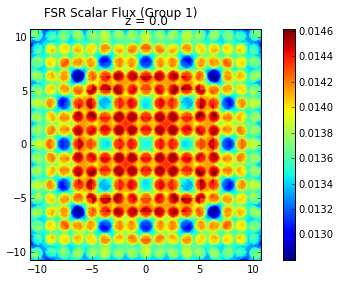

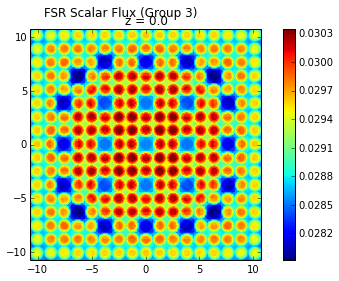

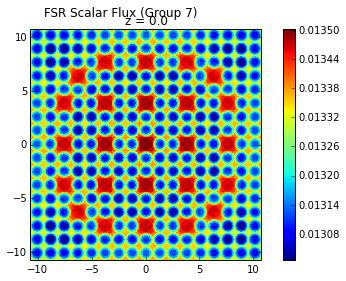

In [24]:
# Plot fast, epithermal and thermal flux
figures = plotter.plot_spatial_fluxes(solver, energy_groups=[1,3,7],
                                      gridsize=500, get_figure=True)
map(lambda fig: fig.set_figheight(4), figures)
plt.show()

[  NORMAL ]  Plotting the flat source region fission rates...


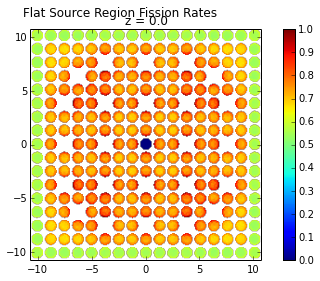

In [25]:
# Plots FSR fission rates
fig = plotter.plot_fission_rates(solver, gridsize=250,
                                 norm=True, get_figure=True)
fig.set_figheight(4)
plt.show()